In [1]:
import torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy,Mean,Metric
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from einops import rearrange

from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.conv import *
from diy_stable_diffusion.learner import *
from diy_stable_diffusion.activations import *
from diy_stable_diffusion.training import *
from diy_stable_diffusion.init import *
from diy_stable_diffusion.sgd import *
from diy_stable_diffusion.resnet import *
from diy_stable_diffusion.augment import *
from diy_stable_diffusion.accel import *

from  diy_stable_diffusion.attention import *

In [2]:
def saveobj(obj, name):
    now = datetime.datetime.now()
    date = now.date().isoformat()
    randstr = hex(abs(hash(now))).replace('0x', '')[:8]
    filepath=f'models/{date}-{name}-{randstr}.pkl'
    torch.save(obj, filepath)

In [3]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
@inplace
def transformi(b):
    img = [TF.to_tensor(o).flatten() for o in b[xl]]
    b[yl] = b[xl] = img

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [6]:
dl = dls.valid
xb,yb = b = next(iter(dl))

In [7]:
def init_weights(module, leaky=0.):
    if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Linear)):
        init.kaiming_normal_(module.weight, a=leaky)

In [8]:
init_weights_partial = partial(init_weights, leaky=0.2)

In [9]:
n_in=784
n_hidden=400
n_latents=200


In [10]:
opt_func = partial(optim.Adam, eps=1e-5)


# Simple autoencoder

In [8]:
def lin(n_in, n_out, act=nn.SiLU, norm=nn.BatchNorm1d, bias=True):
    layers = nn.Sequential(nn.Linear(n_in, n_out, bias=bias))
    if act:
        layers.append(act())
    if norm:
        layers.append(norm(n_out))
    
    return layers

In [11]:
class Autoenc(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc=nn.Sequential(
            lin(n_in, n_hidden),
            lin(n_hidden, n_hidden),
            lin(n_hidden, n_latents)
        )
        
        self.dec = nn.Sequential(
            lin(n_latents, n_hidden),
            lin(n_hidden, n_hidden),
            lin(n_hidden, n_in, act=None)
        )
        init_weights_partial(self)
    def forward(self, x):
        return self.dec(self.enc(x))

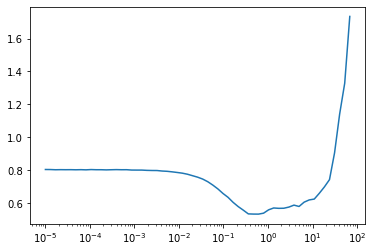

In [40]:
Learner(Autoenc(), dls, nn.BCEWithLogitsLoss(), cbs=[DeviceCB(), MixedPrecision()],
        opt_func=opt_func).lr_find()

In [41]:
lr = 3e-2
epochs=20
tmax=epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model=Autoenc()
learn=Learner(model, dls, nn.BCEWithLogitsLoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.723,0,train
0.631,0,eval


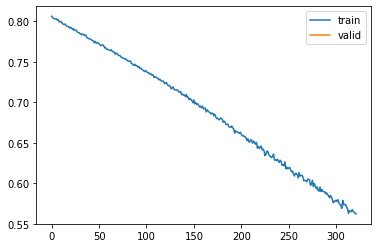

In [ ]:
# learn.fit(epochs)
# torch.save(learn.model, 'models/2024-01-24-vaesimple-usefhfe.pkl')

In [23]:
'''
junk model, but anyway, renamed to autoencsimple, it's not a vae
'''
model=torch.load('models/2024-01-24-vaesimple-usefhfe.pkl')

In [24]:
learn.model = model

loss,epoch,train
nan,0,eval


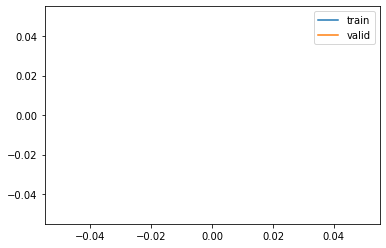

In [26]:
learn.fit(1, do_train=False, do_validate=True)

In [29]:
xb,_ = (next(iter(dls.train)))

loss,epoch,train
nan,0,eval


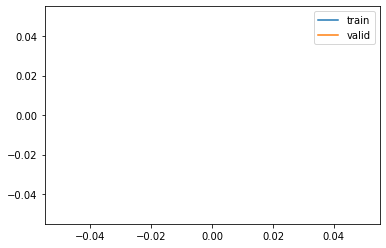

In [31]:
result=learn.capture_preds()


In [42]:
'''
try again. last model failed. didn't converge, nan loss, nan preds.

update: works great now, thanks
'''
lr = 3e-2
epochs=20
tmax=epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model=Autoenc()
learn=Learner(model, dls, nn.BCEWithLogitsLoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.528,0,train
0.465,0,eval
0.400,1,train
0.351,1,eval
0.316,2,train
0.305,2,eval
0.286,3,train
0.284,3,eval
0.276,4,train
0.277,4,eval


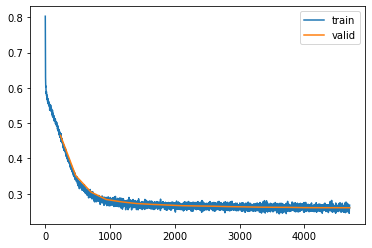

In [161]:
'''
note: renamed to autoencsimple-2. it's not a vae.
'''
learn.fit(epochs)
saveobj(learn.model, 'vaesimple-2')

loss,epoch,train
0.260,0,eval


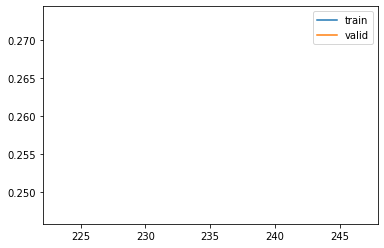

In [162]:
learn.fit(1, do_train=False, do_validate=True)

In [164]:
xb,_ = next(iter(dls.train))

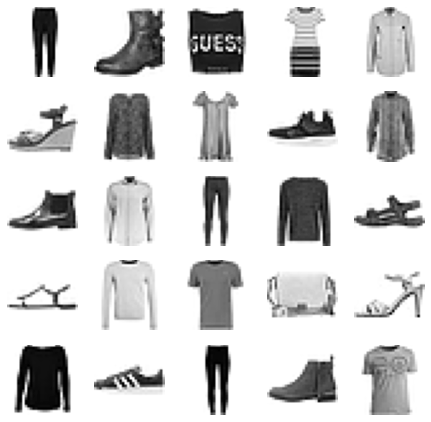

In [168]:
show_images(xb[:25].view(-1, 1, 28, 28), imsize=1.5)

Note: look how much better sigmoid is. Why is it so much better than the original output which was directly subjected to a BCE loss function?

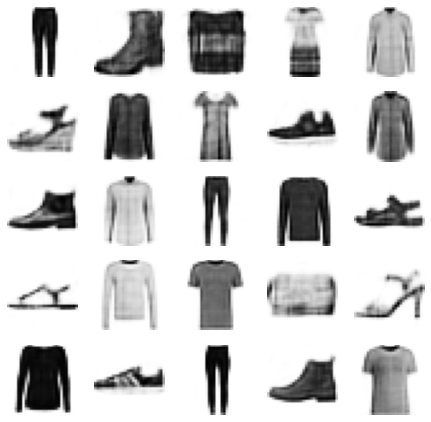

In [173]:
'''
sigmoid included
'''
show_images(learn.model(xb[:25].cuda()).view(-1, 1, 28, 28).sigmoid(), imsize=1.5)

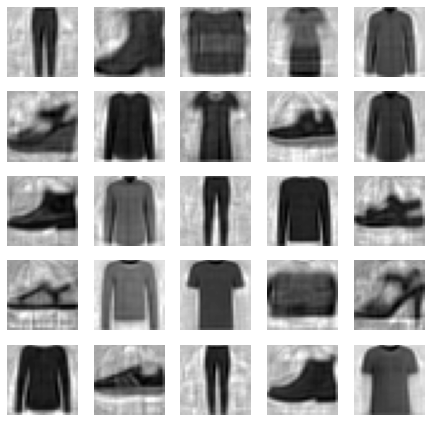

In [174]:
'''
no sigmoid
'''
show_images(learn.model(xb[:25].cuda()).view(-1, 1, 28, 28), imsize=1.5)

# VAE

In [11]:
class VAE(nn.Module):
    def __init__(self):
        # remember to call init on module
        super().__init__()
        
        # enc: in to hidden
        self.enc = nn.Sequential(
            lin(n_in, n_hidden),
            lin(n_hidden, n_hidden)
        )

        # mu, lv: hidden to latent size
        self.mu = lin(n_hidden, n_latents, act=None)
        self.lv = lin(n_hidden, n_latents, act=None)

        # dec: latent back to in
        self.dec = nn.Sequential(
            lin(n_latents, n_hidden),
            lin(n_hidden, n_hidden),
            lin(n_hidden, n_in, act=None) # remember act=None for output layers
        )

        # remember to initialize weights
        init_weights_partial(self)
    
    def forward(self, x):
        x = self.enc(x)
        
        mu_x = self.mu(x)
        lv_x = self.lv(x)
        x = mu_x + (lv_x/2).exp() * torch.randn_like(mu_x)
        
        return self.dec(x), mu_x, lv_x # return mu, lv in order to run loss funcs incorporating them

In [ ]:
'''
mu_x, lv_x are the calculated mean and log-variance tensors for each pixel in each image of batch
after the model's forward pass

both size (batch_size, height, width)
'''
def kdl_loss(mu_x, lv_x):
    # var = (lv_x).exp()
    # return -0.5 * (1 + lv_x - mu_x**2 - var).mean()
    return -0.5 * (1 + lv_x - mu_x.pow(2) - lv_x.exp()).mean()

def vae_combined_loss(inp, act_x):
    pred_x, mu_x, lv_x = inp
    return kdl_loss(mu_x, lv_x) + F.binary_cross_entropy_with_logits(pred_x, act_x)

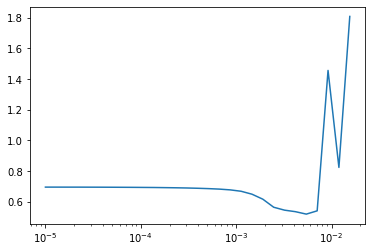

In [13]:
Learner(VAE(), dls, vae_combined_loss, cbs=[DeviceCB(), MixedPrecision()], opt_func=opt_func).lr_find()

In [16]:
xb,yb=next(iter(dls.train))
xb.min(),xb.max(),xb.mean(),yb.min(),yb.max(),yb.mean()

(tensor(0.),
 tensor(1.),
 tensor(0.2820),
 tensor(0.),
 tensor(1.),
 tensor(0.2820))

In [17]:
bs

256

In [14]:
model = VAE()
lr = 1e-1
epochs=20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
learn=Learner(model, dls, vae_combined_loss, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.434,0,train
0.399,0,eval
0.399,1,train
0.411,1,eval
nan,2,train
nan,2,eval
nan,3,train
nan,3,eval


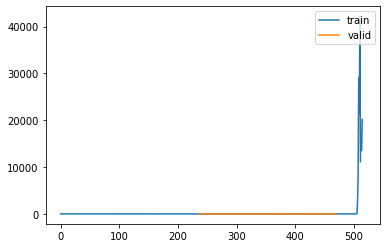

KeyboardInterrupt: 

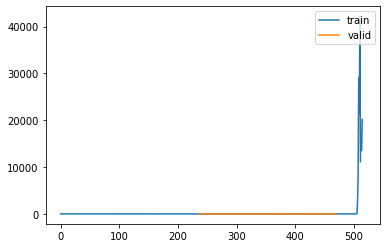

In [15]:
'''
final loss 0.439 compared to Jeremy's 0.341
'''
learn.fit(epochs)
# saveobj(learn.model, 'vae1')

In [18]:
model = VAE()
lr = 3e-2
epochs=20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
learn=Learner(model, dls, vae_combined_loss, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.459,0,train
0.419,0,eval
0.395,1,train
0.379,1,eval
0.383,2,train
0.382,2,eval
nan,3,train
nan,3,eval
nan,4,train
nan,4,eval


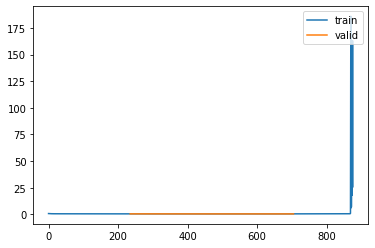

In [19]:
'''
running this to start on the cloned machine to verify everything is runnable
'''
learn.fit(epochs)

In [207]:
model = VAE()
lr = 3e-2
epochs=20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
learn=Learner(model, dls, vae_combined_loss, cbs=cbs, opt_func=opt_func)

In [ ]:
'''
killed again at epoch 4, eval=.492 compared to Jeremy's .380
'''
learn.fit(epochs)
saveobj(learn.model, 'vae2-lr3eneg2')

My everything again

Results: as good as original.
WTF?

    0.976 	0 	train
    0.772 	0 	eval
    0.545 	1 	train
    0.450 	1 	eval
    0.417 	2 	train
    0.398 	2 	eval

That was first try. Now restart nb, try again
    working... epoch 4 eval loss 0.382 compared to Jeremy's 0.380
    
My code seems to be working now, didn't execute any of Jeremy's code

Probably I had a notebook state bug of some type, where I didn't properly reset some variables or states related to the learner. Need to be less hasty next time and just try again carefully before starting to do lots of crazy experiments to figure out what's wrong.

In [15]:
model = VAE()
lr = 3e-2
epochs=20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
learn=Learner(model, dls, vae_combined_loss, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.973,0,train
0.805,0,eval
0.545,1,train
0.453,1,eval
0.417,2,train
0.400,2,eval
0.391,3,train
0.389,3,eval
0.384,4,train
0.382,4,eval


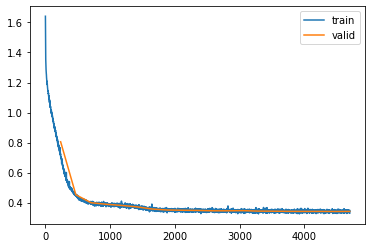

In [16]:
learn.fit(epochs)

In [17]:
torch.save(learn.model, 'models/2024-01-25-my_own_vae_working-usefiuh.pkl')

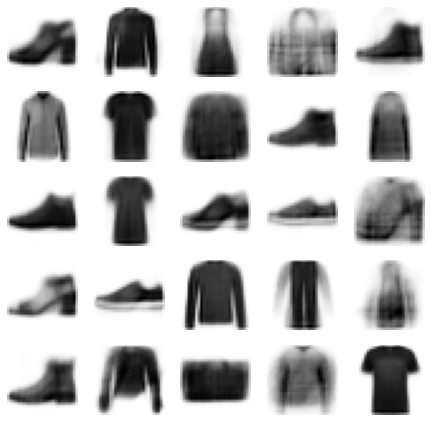

In [24]:
show_images(model.dec(torch.randn((25, n_latents)).cuda()).view(-1, 1, 28, 28).sigmoid(), imsize=1.5)

that's all I'm happy now k thanks bye

just kidding

# VAE 2d

In [25]:
'''
what about directly displaying latents, 200->14x14 ims?
'''
xb.shape

torch.Size([256, 784])

In [28]:
latents = model.enc(xb.cuda())

In [30]:
latents.shape

torch.Size([256, 400])

<AxesSubplot:>

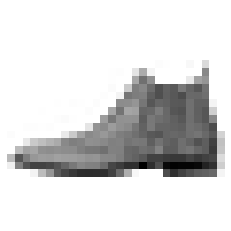

In [34]:
show_image(xb[0].reshape(28,28))

<AxesSubplot:>

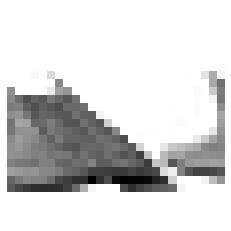

In [32]:
show_image(xb[0][:729].reshape(27,27))

<AxesSubplot:>

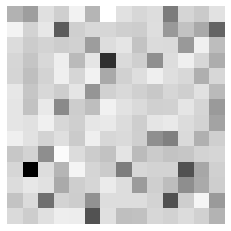

In [35]:
show_image(latents[0][:196].reshape(14,14).cpu())

In [44]:
upsample_and_conv??

Signature: upsample_and_conv(channels)
Docstring: <no docstring>
Source:   
def upsample_and_conv(channels):
    return nn.Sequential(
        nn.Upsample(scale_factor=2.0),
        nn.Conv2d(channels, channels, 3, padding=1) # 1 == (ks=3)//2
    )
File:      /usr/local/lib/python3.9/dist-packages/diy_stable_diffusion/attention.py
Type:      function


In [48]:
@inplace
def transformi(b):
    img = [TF.to_tensor(o) - 0.5 for o in b[xl]]
    b[yl] = b[xl] = img

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [57]:
xb,yb=(next(iter(dls.train)))

<AxesSubplot:>

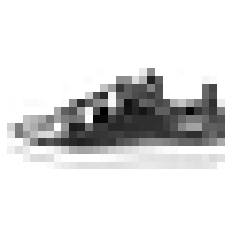

In [58]:
show_image(xb[0])

<AxesSubplot:>

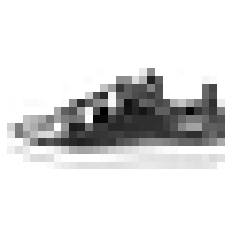

In [59]:
show_image(yb[0])

In [63]:
torch.equal(xb[0], yb[0])

True

In [82]:
xb[0][0].shape, xb[0].min(), xb[0].max()

(torch.Size([28, 28]), tensor(-0.5000), tensor(0.5000))

In [84]:
u=nn.Upsample(scale_factor=2.0, mode='nearest')(xb[0][None])

torch.Size([1, 1, 56, 56])

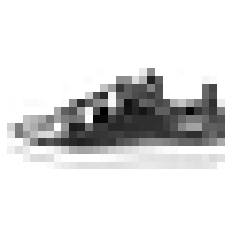

In [86]:
show_image(u[0])
u.shape

In [95]:
upsample_and_conv??

Signature: upsample_and_conv(channels)
Docstring: <no docstring>
Source:   
def upsample_and_conv(channels):
    return nn.Sequential(
        nn.Upsample(scale_factor=2.0),
        nn.Conv2d(channels, channels, 3, padding=1) # 1 == (ks=3)//2
    )
File:      /usr/local/lib/python3.9/dist-packages/diy_stable_diffusion/attention.py
Type:      function


In [106]:
class AutoencSimple2D(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.enc = nn.Sequential(
            conv(1, 1, stride=1, bias=True, norm=nn.BatchNorm2d), #1 x 28 x 28
            conv(1, 3, bias=True, norm=nn.BatchNorm2d), #3 x 14 x 14
            conv(3, 3, stride=1, bias=True, norm=nn.BatchNorm2d), # 3 x 14 x 14
            conv(3, 3, bias=True, norm=nn.BatchNorm2d) # 3 x 7 x 7
        )
        
        self.dec = nn.Sequential(
            conv(3, 3, stride=1, bias=True), # 3 x 7 x 7
            conv(3, 3, stride=1, bias=True), # 3 x 7 x 7
            upsample_and_conv(3), # 3 x 14 x 14
            conv(3, 3, stride=1, bias=True), # 3 x 14 x 14
            conv(3, 3, stride=1, bias=True), # 3 x 14 x 14
            upsample_and_conv(3), # 3 x 28 x 28
            conv(3, 1, stride=1, bias=False) # 1 x 28 x 28
        )
        
        init_weights_partial(self)
    
    def forward(self, x):
        return self.dec(self.enc(x))

In [107]:
model=AutoencSimple2D().cuda()

In [108]:
result=model(xb.cuda())
result.shape

torch.Size([256, 1, 28, 28])

<AxesSubplot:>

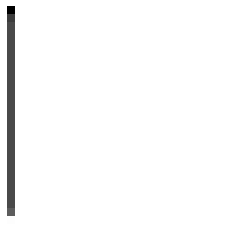

In [109]:
show_image(result[0].cpu())

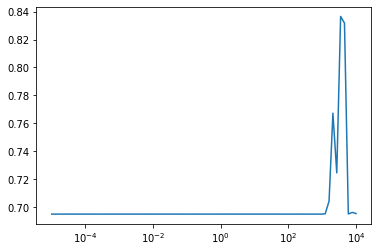

In [110]:
Learner(model, dls, nn.BCEWithLogitsLoss(), cbs=[DeviceCB(), MixedPrecision()], opt_func=opt_func).lr_find()

In [111]:
model = AutoencSimple2D()
lr = 3e-2
epochs=20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
learn=Learner(model, dls, nn.BCEWithLogitsLoss(), cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.719,0,train
0.719,0,eval


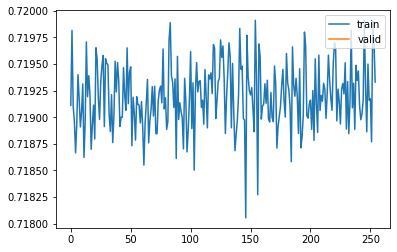

KeyboardInterrupt: 

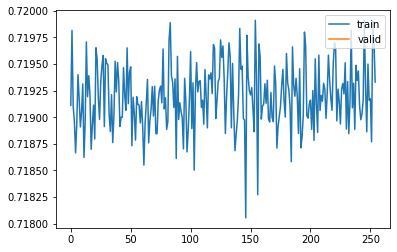

In [112]:
learn.fit(epochs)
saveobj(learn.model, 'autoenc2d')